# IMPORT LIBRARIES & GLOBAL CONFIG

In [37]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pathlib import Path
import warnings
import soundfile as sf

warnings.filterwarnings('ignore')
sns.set(style='whitegrid', palette='muted')
pd.set_option('display.max_columns', None)

# INPUT CONFIG 

In [ ]:
AUDIO_ROOT = './dataset3'
DATASET_NAME = "Dataset 3"
SAMPLE_RATE_TARGET = 16000
AUDIO_EXT = ('.wav', '.mp3', '.flac', '.ogg')

# HELPER FUNCTION

In [39]:
def scan_folder_structure(root_path):
    """Scan folder structure Label/File.audio → return DataFrame(file_path, label)"""
    data = []
    root = Path(root_path)
    
    if not root.exists():
        print(f"Error: Folder '{root_path}' does not exist.")
        return pd.DataFrame()

    for label_dir in root.iterdir():
        if label_dir.is_dir():
            label_name = label_dir.name
            for file in label_dir.iterdir():
                if file.suffix.lower() in AUDIO_EXT:
                    data.append({
                        'file_path': str(file),
                        'label': label_name
                    })
    
    return pd.DataFrame(data)


def extract_audio_features(row):
    """Extract Duration, RMS, SR, n_samples"""
    path = row['file_path']
    try:
        y, sr = librosa.load(path, sr=SAMPLE_RATE_TARGET, mono=True)
        duration = librosa.get_duration(y=y, sr=sr)
        rms = librosa.feature.rms(y=y)[0]
        rms_mean = np.mean(rms) if len(rms) > 0 else 0
        
        return pd.Series({
            'duration': duration,
            'rms_mean': rms_mean,
            'sr': sr,
            'n_samples': len(y),
            'read_ok': True,
            'error_msg': None
        })
    except Exception as e:
        return pd.Series({
            'duration': 0,
            'rms_mean': 0,
            'sr': 0,
            'n_samples': 0,
            'read_ok': False,
            'error_msg': str(e)
        })

print(f"Pipeline setup complete for {AUDIO_ROOT}")

Pipeline setup complete for ./cropped_audio


# CROP 1s < ... < 15s

In [ ]:
AUDIO_ROOT = './dataset3'
OUTPUT_ROOT = './dataset3_cropped'
SEG_LEN = 15.0
AUDIO_EXT = {'.wav', '.mp3', '.flac', '.ogg'}

os.makedirs(OUTPUT_ROOT, exist_ok=True)

print("\n=== SIMPLE CROP LOGIC (<15s keep, >=15s split into full 15s parts) ===\n")

root = Path(AUDIO_ROOT)

for label_dir in root.iterdir():
    if not label_dir.is_dir():
        continue

    label = label_dir.name
    print(f"\n>>> Processing label: {label}")

    out_label_dir = Path(OUTPUT_ROOT) / label
    out_label_dir.mkdir(parents=True, exist_ok=True)

    files = [f for f in label_dir.iterdir() if f.suffix.lower() in AUDIO_EXT]

    for file in files:
        try:
            y, sr = librosa.load(file, sr=None)
            duration = len(y) / sr
            seg_samples = int(SEG_LEN * sr)
            base = file.stem
            ext = ".wav"

            # ------ CASE 1: Keep < 15s ------
            if duration < SEG_LEN:
                out_path = out_label_dir / f"{base}{ext}"
                sf.write(out_path, y, sr)
                print(f"Keep: {out_path}")
                continue

            # ------ CASE 2: Split into 15s chunks ------
            total_parts = len(y) // seg_samples

            for i in range(total_parts):
                start = i * seg_samples
                end = start + seg_samples
                segment = y[start:end]

                out_name = f"{base}_part{i}{ext}"
                out_path = out_label_dir / out_name
                sf.write(out_path, segment, sr)

                print(f"Part {i}: {out_path}")

        except Exception as e:
            print(f"Error reading {file}: {e}")

print("\n=== DONE ===")


# PREPROCESSING

In [41]:
print(f"\n=== I. CLEANING PIPELINE ({DATASET_NAME}) ===")

df = scan_folder_structure(AUDIO_ROOT)
print(f"-> Total files scanned: {len(df)}")

if len(df) > 0:
    df['label_clean'] = df['label'].astype(str).str.lower().str.strip()

    print(f"-> Original labels: {df['label'].unique()}")
    print(f"-> Normalized labels: {df['label_clean'].unique()}")

    n_dups = df.duplicated(subset=['file_path']).sum()
    if n_dups > 0:
        df = df.drop_duplicates(subset=['file_path'])
    else:
        print("-> No duplicate file paths.")

    missing = df.isnull().sum().sum()
    print(f"-> Total missing values: {missing}")

else:
    print("No data found!")


=== I. CLEANING PIPELINE (Dataset 3) ===
-> Total files scanned: 177
-> Original labels: ['Angry' 'Happy' 'Neutral' 'Sad']
-> Normalized labels: ['angry' 'happy' 'neutral' 'sad']
-> No duplicate file paths.
-> Total missing values: 0


# EDA

In [42]:
print(f"\n=== II. DESCRIPTIVE STATS & AUDIO FEATURES ({DATASET_NAME}) ===")
print("(Reading audio files to extract features... please wait)")

if len(df) > 0:
    # Extract audio features (Duration, RMS, SR, n_samples)
    audio_stats = df.apply(extract_audio_features, axis=1)
    
    # Merge back to main DataFrame
    df_full = pd.concat([df, audio_stats], axis=1)
    
    # Keep only successfully read files
    df_valid = df_full[df_full['read_ok'] == True].copy()
    
    # --- Filter audio 1 ≤ duration ≤ 15 seconds ---
    MIN_DURATION = 1
    MAX_DURATION = 15.0
    df_valid = df_valid[(df_valid['duration'] >= MIN_DURATION) & (df_valid['duration'] <= MAX_DURATION)]
    df_valid = df_valid.reset_index(drop=True)
    
    print(f"\nAfter filtering files {MIN_DURATION}-{MAX_DURATION}s, remaining {len(df_valid)} files")
    
    # --- 2.1 Basic statistics ---
    print(f"\n[2.1 Basic statistics]")
    print(f"- Total samples: {len(df_valid)}")
    print(f"- Number of columns: {df_valid.shape[1]}")
    
    # --- 2.2 Audio feature statistics ---
    print(f"\n[2.2 Audio feature statistics]")
    
    # Duration stats
    desc_dur = df_valid['duration'].describe()
    var_dur = df_valid['duration'].var()
    iqr_dur = desc_dur['75%'] - desc_dur['25%']
    
    print(f"\n>>> Duration:")
    print(f"  Mean: {desc_dur['mean']:.2f} s")
    print(f"  Median: {desc_dur['50%']:.2f} s")
    print(f"  Min / Max: {desc_dur['min']:.2f} / {desc_dur['max']:.2f} s")
    print(f"  Variance: {var_dur:.2f}")
    print(f"  IQR: {iqr_dur:.2f}")
    
    # RMS stats
    desc_rms = df_valid['rms_mean'].describe()
    var_rms = df_valid['rms_mean'].var()
    
    print(f"\n>>> RMS (Loudness):")
    print(f"  Mean: {desc_rms['mean']:.4f}")
    print(f"  Median: {desc_rms['50%']:.4f}")
    print(f"  Variance: {var_rms:.6f}")
    
    # Check frequency
    print(f"\n>>> Sample Rate:")
    wrong_sr_count = df_valid[df_valid['sr'] != SAMPLE_RATE_TARGET].shape[0]
    print(f"  Target SR: {SAMPLE_RATE_TARGET} Hz")
    print(f"  Files with wrong SR: {wrong_sr_count} file(s)")


=== II. DESCRIPTIVE STATS & AUDIO FEATURES (Dataset 3) ===
(Reading audio files to extract features... please wait)

After filtering files 1-15.0s, remaining 169 files

[2.1 Basic statistics]
- Total samples: 169
- Number of columns: 9

[2.2 Audio feature statistics]

>>> Duration:
  Mean: 7.27 s
  Median: 6.25 s
  Min / Max: 1.46 / 15.00 s
  Variance: 18.30
  IQR: 6.34

>>> RMS (Loudness):
  Mean: 0.0653
  Median: 0.0508
  Variance: 0.001781

>>> Sample Rate:
  Target SR: 16000 Hz
  Files with wrong SR: 0 file(s)


In [43]:
print(f"\n=== III. LABEL DISTRIBUTION ANALYSIS ({DATASET_NAME}) ===")

if len(df) > 0:
    # 3.1 Check imbalance
    label_counts = df['label_clean'].value_counts()
    label_percents = df['label_clean'].value_counts(normalize=True) * 100
    
    print("\n[3.1 Class percentage]")
    print(label_percents)
    
    # Imbalance ratio
    max_ratio = label_counts.max() / label_counts.min()
    print(f"\nMax/Min Ratio: {max_ratio:.2f}")


=== III. LABEL DISTRIBUTION ANALYSIS (Dataset 3) ===

[3.1 Class percentage]
label_clean
neutral    31.073446
angry      26.553672
sad        24.858757
happy      17.514124
Name: proportion, dtype: float64

Max/Min Ratio: 1.77


Dataset shows mild imbalance; the gap between the largest and smallest class is not large, but should still be considered when evaluating the model, especially for the happy class.


=== IV. UNIVARIATE VISUALIZATION (Dataset 3) ===
► Showing audio files from 0.5 to 15.0s, total 169 files


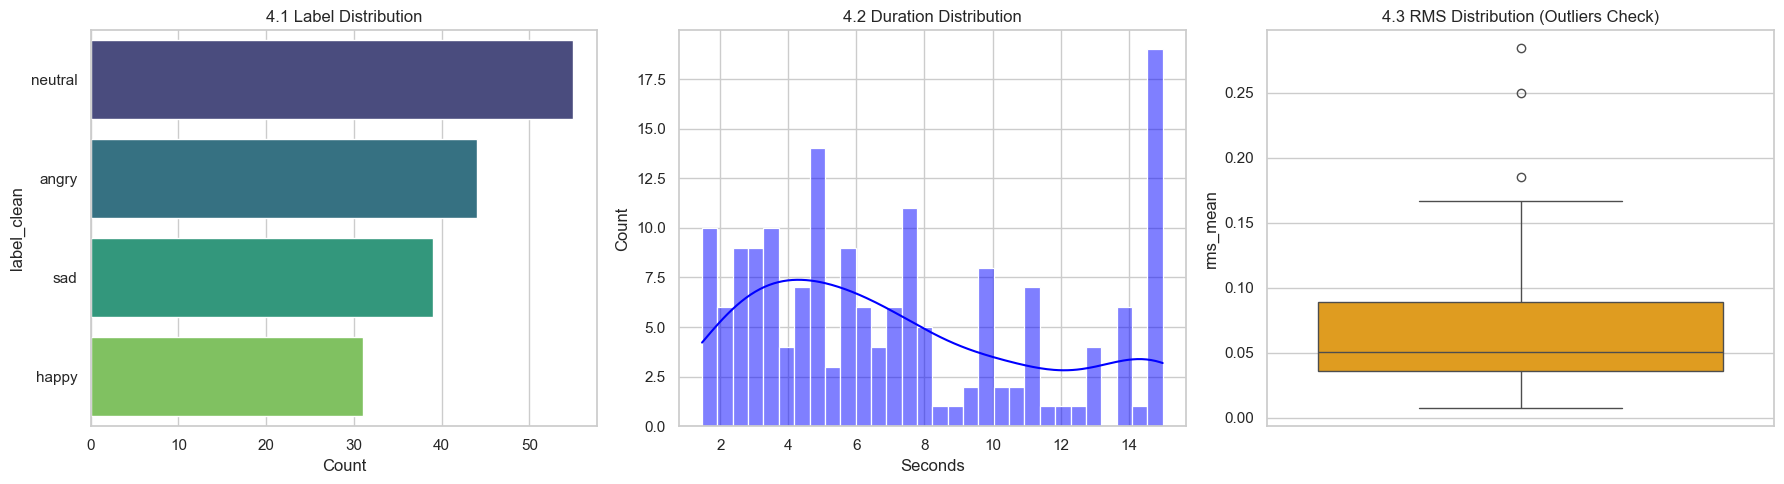

In [44]:
print(f"\n=== IV. UNIVARIATE VISUALIZATION ({DATASET_NAME}) ===")

if len(df_valid) > 0:
    # Filter audio between 0.5 → 15 seconds
    MIN_DURATION = 0.5
    MAX_DURATION = 15.0
    df_plot = df_valid[(df_valid['duration'] >= MIN_DURATION) & (df_valid['duration'] <= MAX_DURATION)].copy()
    
    print(f"► Showing audio files from {MIN_DURATION} to {MAX_DURATION}s, total {len(df_plot)} files")
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 4.1 Label distribution
    sns.countplot(y=df_plot['label_clean'], ax=axes[0], 
                  order=df_plot['label_clean'].value_counts().index, palette='viridis')
    axes[0].set_title('4.1 Label Distribution')
    axes[0].set_xlabel('Count')
    
    # 4.2 Duration distribution (Histogram)
    sns.histplot(df_plot['duration'], kde=True, ax=axes[1], color='blue', bins=30)
    axes[1].set_title('4.2 Duration Distribution')
    axes[1].set_xlabel('Seconds')
    
    # 4.3 RMS distribution (Boxplot)
    sns.boxplot(y=df_plot['rms_mean'], ax=axes[2], color='orange')
    axes[2].set_title('4.3 RMS Distribution (Outliers Check)')
    
    plt.tight_layout()
    plt.show()
    
    # Check Duration Outliers (> Mean + 3*STD)
    mean_dur = df_plot['duration'].mean()
    std_dur = df_plot['duration'].std()
    outliers = df_plot[df_plot['duration'] > mean_dur + 3*std_dur]

Dataset 3 has an average duration that falls within a reasonable range and can be considered relatively balanced.


=== V. MULTIVARIATE VISUALIZATION (Dataset 3) ===


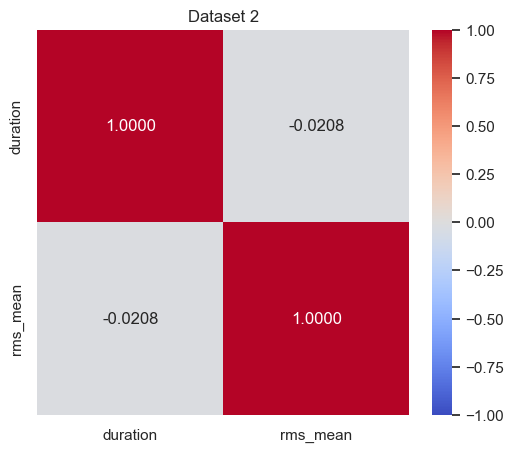

-> Pearson correlation (Duration vs RMS): r = -0.0208

[5.2 VIF results]
    Feature       VIF
0  duration  2.073299
1  rms_mean  2.073299


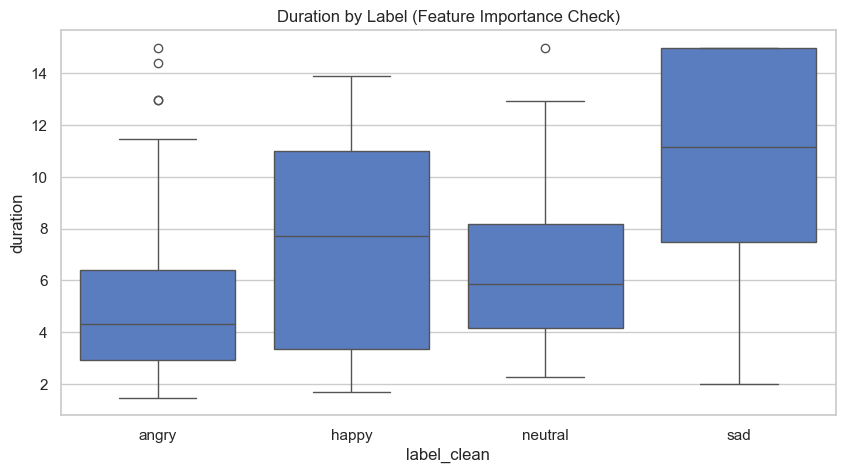

In [45]:
print(f"\n=== V. MULTIVARIATE VISUALIZATION ({DATASET_NAME}) ===")

if len(df_valid) > 0:
    # 5.1 Correlation heatmap
    cols_corr = ['duration', 'rms_mean']
    corr_matrix = df_valid[cols_corr].corr()
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(corr_matrix, annot=True, fmt=".4f", cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Dataset 2')
    plt.show()
    
    # Pearson correlation Duration vs RMS
    r_pearson = df_valid['duration'].corr(df_valid['rms_mean'])
    print(f"-> Pearson correlation (Duration vs RMS): r = {r_pearson:.4f}")
    
    # 5.2 Multicollinearity (VIF)
    # Only compute VIF for Duration and RMS (potential input features)
    X_vif = df_valid[['duration', 'rms_mean']].dropna()
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    
    print("\n[5.2 VIF results]")
    print(vif_data)

    # 5.3 Feature importance view (Boxplot by label)
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df_valid, x='label_clean', y='duration')
    plt.title('Duration by Label (Feature Importance Check)')
    plt.show()

The low RMS variance suggests stable recording quality with minimal sudden fluctuations in amplitude. Because the datasets have undergone pre-processing, all audio files were resampled to the standard training sample rate (16,000 Hz)

In [46]:
print(f"\n=== VI. DATA QUALITY CHECK ({DATASET_NAME}) ===")

if len(df_full) > 0:
    missing_val = df.isnull().sum().sum()
    dup_rows = df.duplicated().sum()
    file_error = df_full[df_full['read_ok'] == False].shape[0]
    audio_mute = df_full[(df_full['read_ok'] == True) & (df_full['rms_mean'] == 0)].shape[0]
    
    print(f"{'Issue type':<25} | {'Count':<10} ")
    print("-" * 50)
    print(f"{'Missing Value':<25} | {missing_val:<10} ")
    print(f"{'Duplicate Rows':<25} | {dup_rows:<10} ")
    print(f"{'Read Error':<25} | {file_error:<10} ")
    print(f"{'Silent Audio (RMS=0)':<25} | {audio_mute:<10} ")


=== VI. DATA QUALITY CHECK (Dataset 3) ===
Issue type                | Count      
--------------------------------------------------
Missing Value             | 0          
Duplicate Rows            | 0          
Read Error                | 0          
Silent Audio (RMS=0)      | 0          


The quality of dataset is good enough for model building.

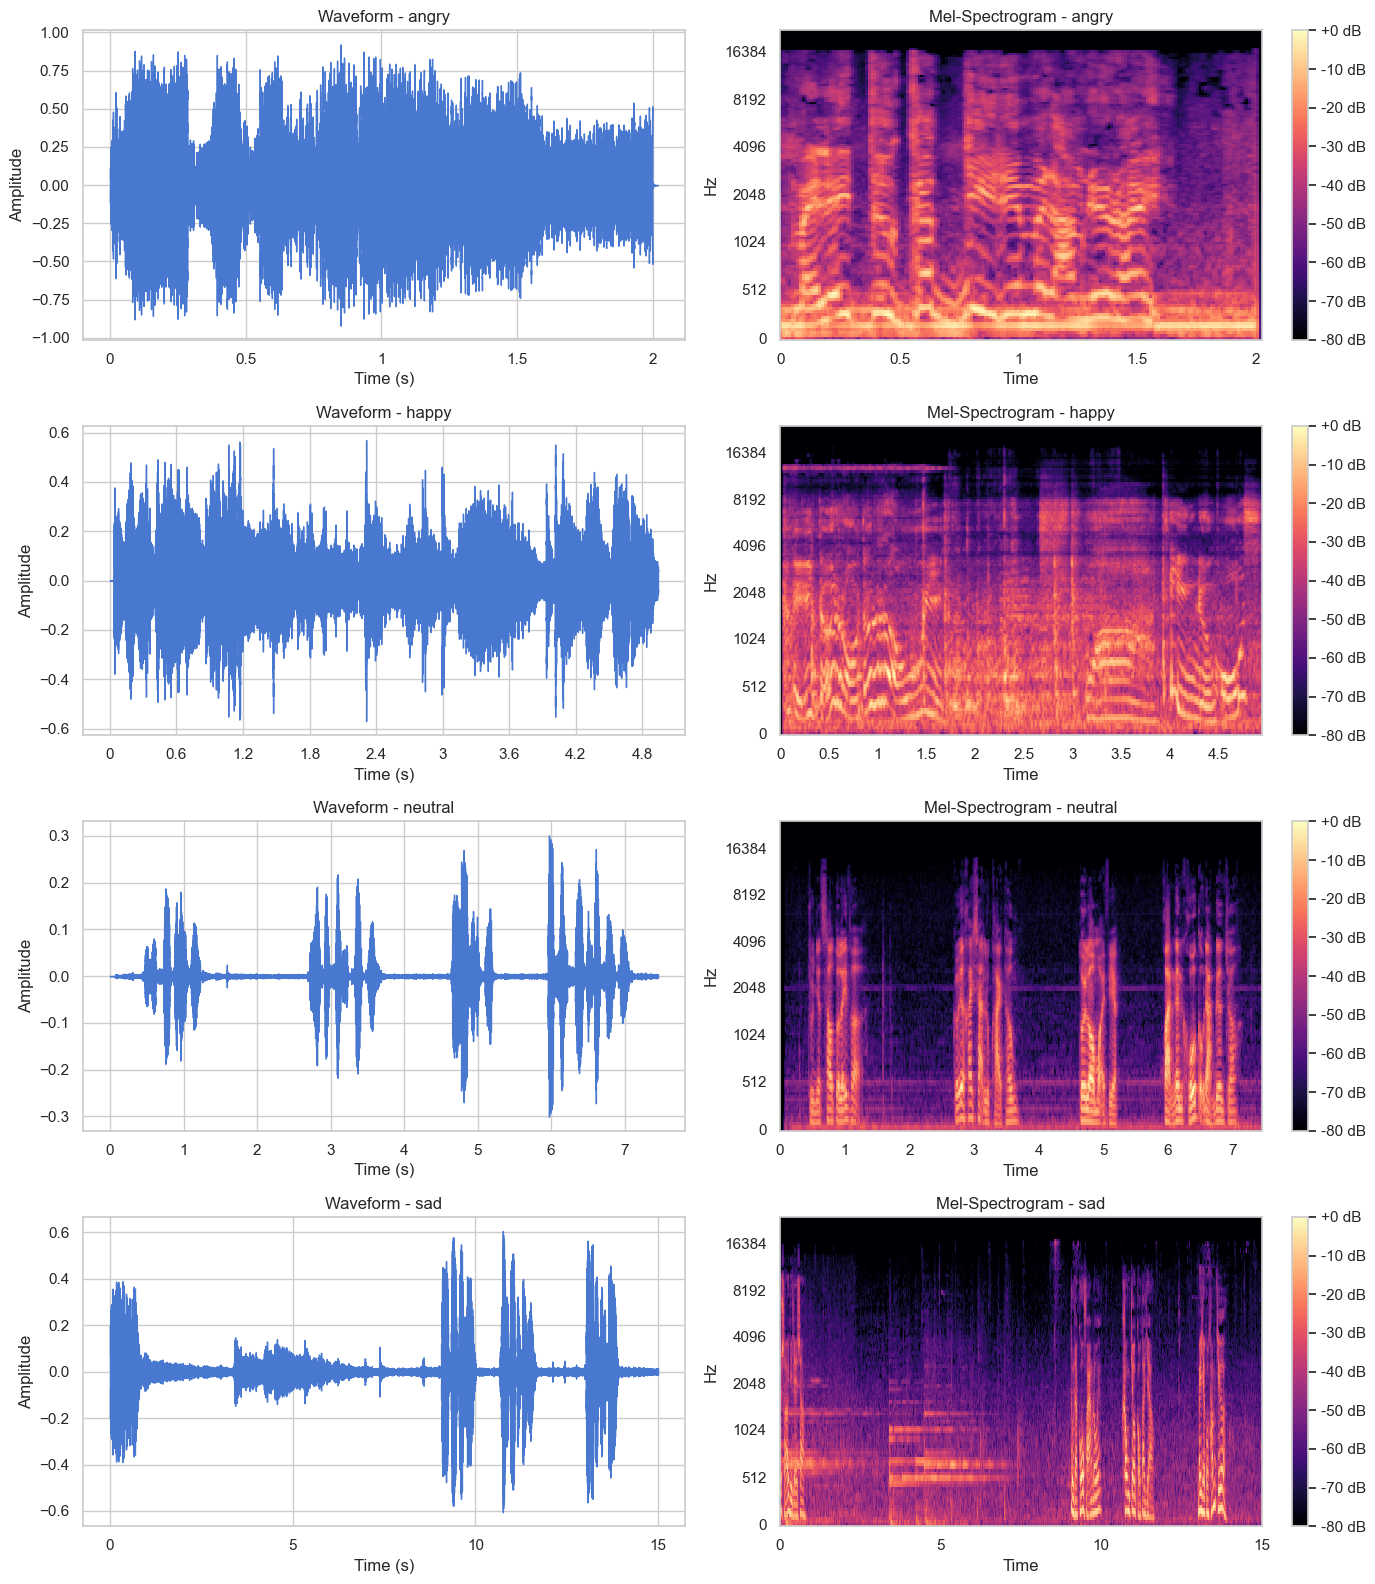

In [47]:
def visualize_dataset3_stacked(df_valid, duration_min=1.0, duration_max=15.0, num_labels=4):
    """
    Visualize stacked waveform and spectrogram for multiple labels (1 row per label).
    Only selects audio between duration_min and duration_max (seconds).
    """
    sample_labels = df_valid['label_clean'].unique()[:num_labels]
    
    # Chọn sample trong khoảng thời lượng
    selected_samples = []
    for lbl in sample_labels:
        candidates = df_valid[df_valid['label_clean'] == lbl]
        for idx, row in candidates.iterrows():
            y, sr = librosa.load(row['file_path'], sr=None)
            dur = librosa.get_duration(y=y, sr=sr)
            if duration_min <= dur <= duration_max:
                selected_samples.append((lbl, row['file_path'], y, sr))
                break  # chỉ lấy 1 file/nghãn
    
    num_samples = len(selected_samples)
    
    plt.figure(figsize=(14, 4*num_samples))
    
    for i, (lbl, path, y, sr) in enumerate(selected_samples):
        # Waveform
        plt.subplot(num_samples, 2, 2*i+1)
        librosa.display.waveshow(y, sr=sr)
        plt.title(f'Waveform - {lbl}')
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        
        # Spectrogram
        plt.subplot(num_samples, 2, 2*i+2)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        S_db = librosa.power_to_db(S, ref=np.max)
        librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Mel-Spectrogram - {lbl}')
    
    plt.tight_layout()
    plt.show()

visualize_dataset3_stacked(df_valid)


- Examination of the waveforms and spectrograms across the three datasets shows that the signal structures are generally clear, with no unusual noise artifacts or spectral distortions.
- The energy levels and spectral spread of the audio files fall within reasonable ranges, indicating that the data is of good quality for deep learning.